# Monte Carlo Method - Blackjack environment

Implementation of Monte Carlo (MC) algorithm. 

### Import the packages

In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

### Create the environment

github link of the environment: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

Reference: Example 5.1 in Sutton's book https://s3-us-west-1.amazonaws.com/udacity-drlnd/bookdraft2018.pdf

OpenAI blackjack documentation: https://www.gymlibrary.dev/environments/toy_text/blackjack/


In [2]:
env = gym.make('Blackjack-v1', natural=False, sab=False)

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Generate an episode based on a Q - Table and using epsilon-greedy policy

In [4]:
# Generates an episode by choosing Actions based on epsilon-greedy policy based on a given Q table
def generate_episode(environment,Q_table,epsilon,nA):
    # epsilon : Probability of choosing highest Q value Action. 1 means equal probablity of all actions being 
    # chosen, 0 means greedy policy, only the action with max Q value will be chosen.
    # epsilon 1 => Exploration
    
    episode = []
    state,info = environment.reset()
    while True:
        if state in Q_table:
            probs = get_probs(nA,epsilon,Q_table[state])
            action = np.random.choice(np.arange(nA), p=probs)
        else:
            action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = environment.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
            break
    return episode

def get_probs(nA,epsilon,Q_state):
    # Epsilon greedy policy
    probs = np.ones(nA)*epsilon/nA
    max_index = np.argmax(Q_state)
    probs[max_index] += 1 - epsilon 
    return probs

In [5]:
def mc_control(env_b,num_episodes,episode_generation_function,alpha,epsilon_begin=1, epsilon_decay=0.998,
               epsilon_min=0.05, gamma=1.0):
    # env_b : The environment
    # num_episodes : The number of episodes to train the agent to estimate the Action-Value function or Q Table
    # generate_episode_function : The function to create a full episode given a Q table
    # alpha : learning rate
    # gamma : discount factor to calculate Return from Rewards
    # epsilon : Probability of choosing highest Q value Action. 1 means equal probablity of all actions being 
    # chosen, 0 means greedy policy, only the action with max Q value will be chosen.
    # epsilon 1 => Exploration

    nA = env_b.action_space.n
    epsilon = epsilon_begin 
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #generte an episode using epsilon-greedy policy
        episode = episode_generation_function(env_b,Q,epsilon,nA)
        #print(episode)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i,state in enumerate(states):
            Q[state][actions[i]] += alpha *( sum(rewards[i:]*discounts[:-(1+i)]) - Q[state][actions[i]])
            
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

### Train the agent

In [6]:
# obtain the estimated optimal policy and action-value function (Q table)
policy, Q = mc_control(env, 500000, generate_episode, 0.02)

Episode 500000/500000.

### Plot the corresponding state-value function.

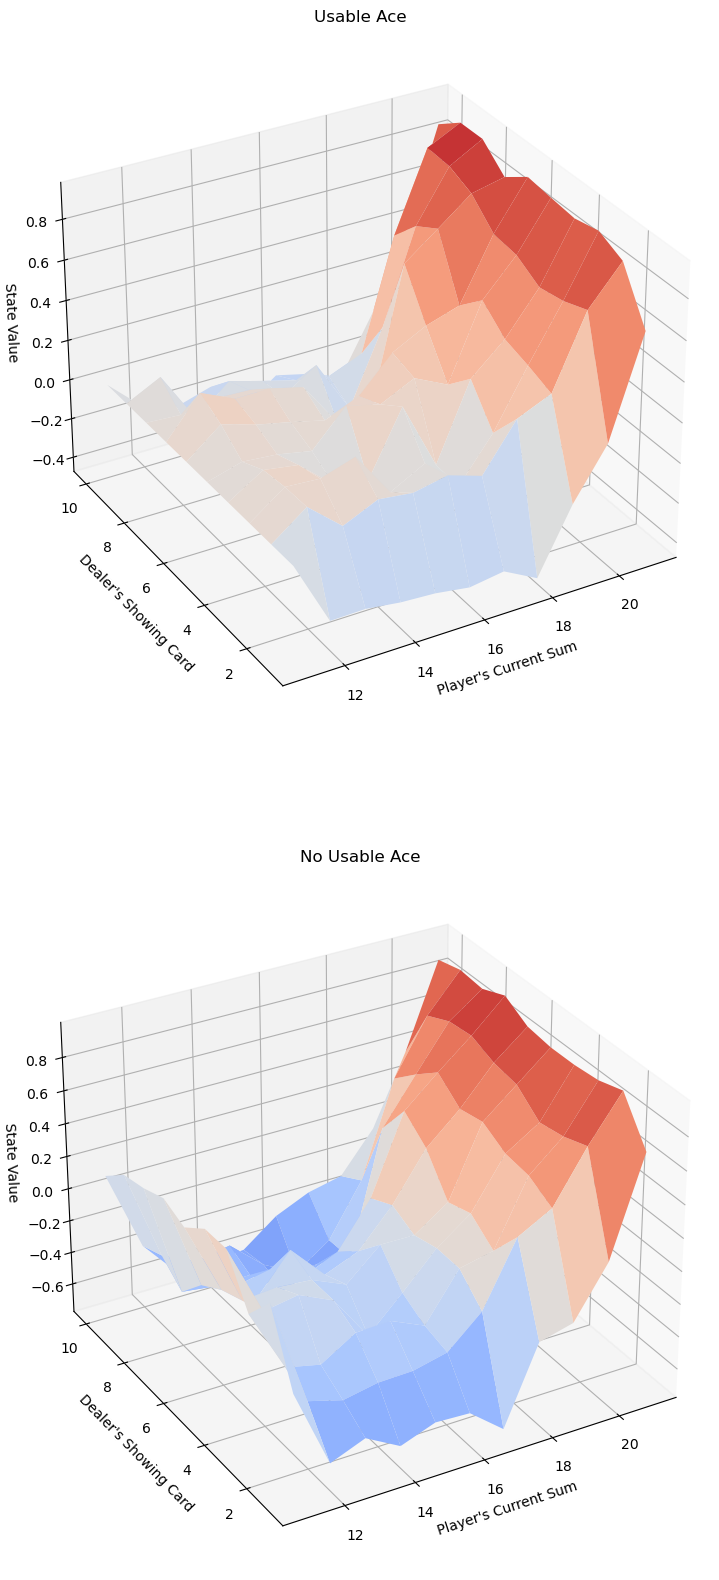

In [8]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

### visualize the policy that is estimated to be optimal.

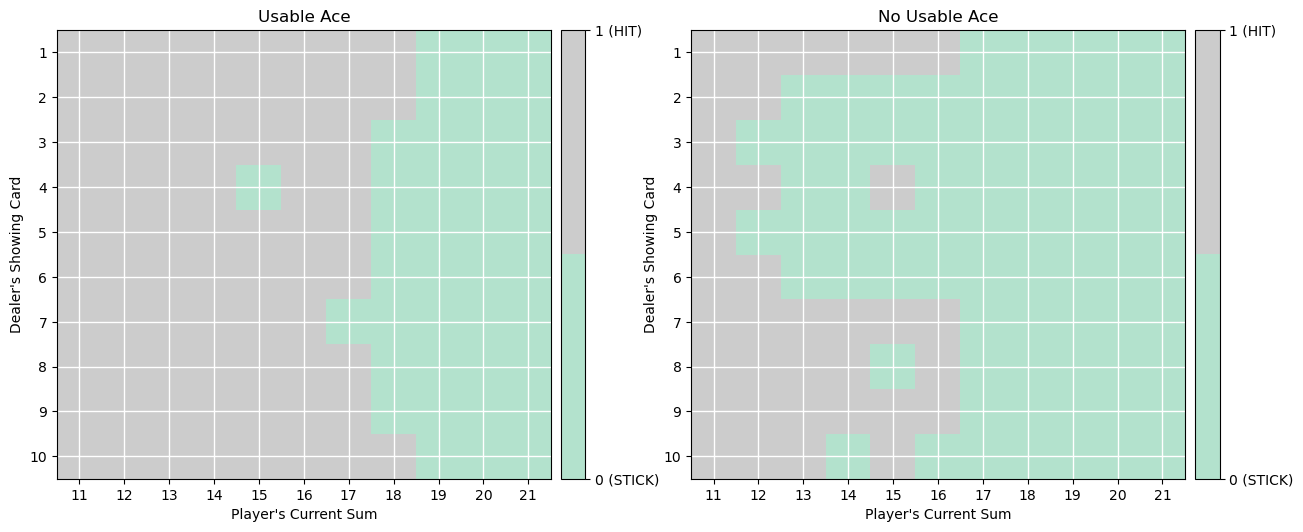

In [9]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).

![True Optimal Policy](images/optimal.png)